In [148]:
import random
from jupyturtle import *

def draw_plant(instructions, angle, length, angle_var=5, length_decay=0.8):
    make_turtle(delay=0, width=300, height=500)
    set_heading(270)
    jp(150, 480)
    set_color("gray")
    hide()

    stack = []
    for cmd in instructions:
        if cmd == 'F':
            fd(length)
        elif cmd == '+':
            rt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '-':
            lt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)

def draw_plant_contextual(instructions, angle, length, length_decay=0.8):
    make_turtle(delay=0, width=400, height=400)
    set_heading(270)
    jp(200, 380)
    set_color("gray")
    hide()

    stack = []
    last_cmd = '1'
    for cmd in instructions:
        if cmd == 'F':
            fd(length)
        elif cmd in ['1', '0']:
            last_cmd = cmd
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            direction = 1 if last_cmd == '1' else -1
            set_heading(t.heading + (angle * direction))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)


In [149]:
import random

def gen_lsystem_stochastic(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        next_str = []
        for char in current:
            if char in rules:
                if isinstance(rules[char], list):
                    next_str.append(random.choice(rules[char])) # stochastic choice
                else:
                    next_str.append(rules[char])
            else:
                next_str.append(char) # might not need this
        current = ''.join(next_str)
    return current

def gen_plant_stochastic():
    config = {
        'axiom': 'F',
        'rules': {
            'F': ['F[+F]F[-F]F', 'F[+F]F', 'F[-F]F'],  # stochastic branching
            'X': 'F[@-FX]+FX'  # flower production rule
        },
        'iterations': 4,
        'angle': 30,
        'length': 15,
        'thickness': 5,
        'angle_var': 10,
        'length_decay': 0.7
    }
    generated_string = gen_lsystem_stochastic(config['axiom'], config['rules'], config['iterations'])
    print(generated_string)    
    draw_plant(generated_string, config['angle'], config['length'], config['angle_var'], config['length_decay'])
    return generated_string

In [150]:
def get_context(c_string, idx):
    env_context = '1'
    ignore = ['[', ']', '+', '-', 'F']

    # find left context
    left_context = env_context
    i = idx
    while i > 0:
        if c_string[i-1] in ['+', '-', 'F']:   # left neighbor is not valid context
            i -= 1
        else:
            if c_string[i-1] == '[':          # left neighbor is an opening bracket
                depth = 0
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == ']':
                        depth += 1
                    elif c_string[j] == '[':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            elif c_string[i-1] == ']':        # left neighbor is a closing bracket
                depth = -1
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            else:                             # left neighbor is a normal character
                left_context = c_string[i-1]
            break
    
    # find right context
    right_context = env_context
    i = idx
    while i < len(c_string) - 1:
        if c_string[i+1] in ['+', '-', 'F']:       # right neighbor is not valid context
            i += 1
        else:
            if c_string[i+1] == ']':          # right neighbor is a closing bracket
                right_context = env_context
            elif c_string[i+1] == '[':        # right neighbor is an opening bracket
                depth = 1
                j = i + 2
                while j < len(c_string) and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j += 1
                if j < len(c_string):
                    right_context = c_string[j]
            else:                             # right neighbor is a normal character
                right_context = c_string[i+1]
            break
    
    return left_context, c_string[idx], right_context

In [151]:
def gen_lsystem_contextual(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        next_str = []
        for i, char in enumerate(current):
            if char not in ['[', ']', '+', '-', 'F']: # char is context-dependent
                context = get_context(current, i)
                if context in rules:
                    next_str.append(rules[context])
                else:
                    print(f'!!! No rule for {context}')
            elif char in ['+', '-']:                  # char is a pitch modifier
                next_str.append(rules[char])
            else:                                     # char is unchanged
                next_str.append(char)
        current = ''.join(next_str)
    return current

def gen_plant_contextual():
    config = {
        'axiom': 'F1F1',
        'rules': {
            ('0', '0', '0'): '0',
            ('0', '0', '1'): '1[+F1]',
            ('0', '1', '0'): '1',
            ('0', '1', '1'): '1',
            ('1', '0', '0'): '0',
            ('1', '0', '1'): '1F1',
            ('1', '1', '0'): '1',
            ('1', '1', '1'): '0',
            '+': '-',
            '-': '+',
        },
        'iterations': 22,
        'angle': 25,
        'length': 10,
        'thickness': 5,
        'length_decay': 0.9
    }
    generated_string = gen_lsystem_contextual(config['axiom'],
                                              config['rules'],
                                              config['iterations'])
    print(generated_string)    
    draw_plant_contextual(generated_string, config['angle'],
                                            config['length'],
                                            config['length_decay'])
    return generated_string

In [152]:
generated_string = gen_plant_contextual()

F0F0F1[+F1F1]F1F1[-F1F0][+F0F0F1[+F1]]F1[-F1F1F1[-F0]F1[+F1F1][-F0F0F0]]F0F0F1[+F1F1][+F1F0F1[+F1]F1[-F0][+F1F1F1]][-F0[-F1[+F1]F1[-F0]]F0F1[+F1][+F0F0F1[+F1]]F1[-F0F0][-F0F1[+F1]F1[-F0F0]]]F0[-F1F0][+F1[-F1F1F1[-F0]]F0[+F1F0F1[+F1]]F1[+F1][-F1F0F0F0[+F1F1][-F0F0F0]]F1[-F0]F1[+F1F1]F0[-F1F0][+F1F1F1[-F1[-F1F1F1[-F0]]]F1[-F0][-F0F0F0][+F1F1F1[-F0]F1[+F1F1]]]]F0[+F0F1[+F1]]F0F1[+F1][-F1F0F0]F1[+F1F1F1[-F0]F0[+F0F1[+F1]]]F0F1[+F1]F1[-F0][+F1F1F1][-F1F0F1[+F1]F1[-F0F0]][+F0[-F0][+F1[+F1F1]]F0[+F1F1][-F0F0F0]F0[+F0F0F0[+F1F1]]][-F0[-F0]F0[+F1F1]F0[-F0F0]F0F0[+F1F1F1][-F0F1[+F1]F1[-F0]]F1[+F0F0F0[+F1F1F1]][-F1F1F1[-F0]F1[+F0F1[+F1]]F0F1[+F1][-F1F0F0]]][+F1F1F1[-F0]F0[+F1F1][+F0[+F0F1[+F1]][+F0[-F1[+F1]F1[-F0]]F1[+F1]F1[+F0F0F1[+F1]]]]F1[-F0F0][-F1[-F1F1F1[-F0]]F0[+F1[-F0]F0[+F1F1]]F1[+F1]F1[-F0][-F0[-F0][+F1[+F1F1]]F0[+F1F1][-F0F0F0]]]F0[+F1F1F1]F0[-F1[+F1]F1[-F0]]F1[+F1]F1[-F0][+F1F0F1[+F1]][-F0[-F0]F0[+F1F1]F1[-F0F0]][+F0F1[+F1]F1[-F0]F1[+F0F1[+F1]]F0F1[+F1][-F1F0F0][+F1[+F1]F1[-F0]F0[+F1F

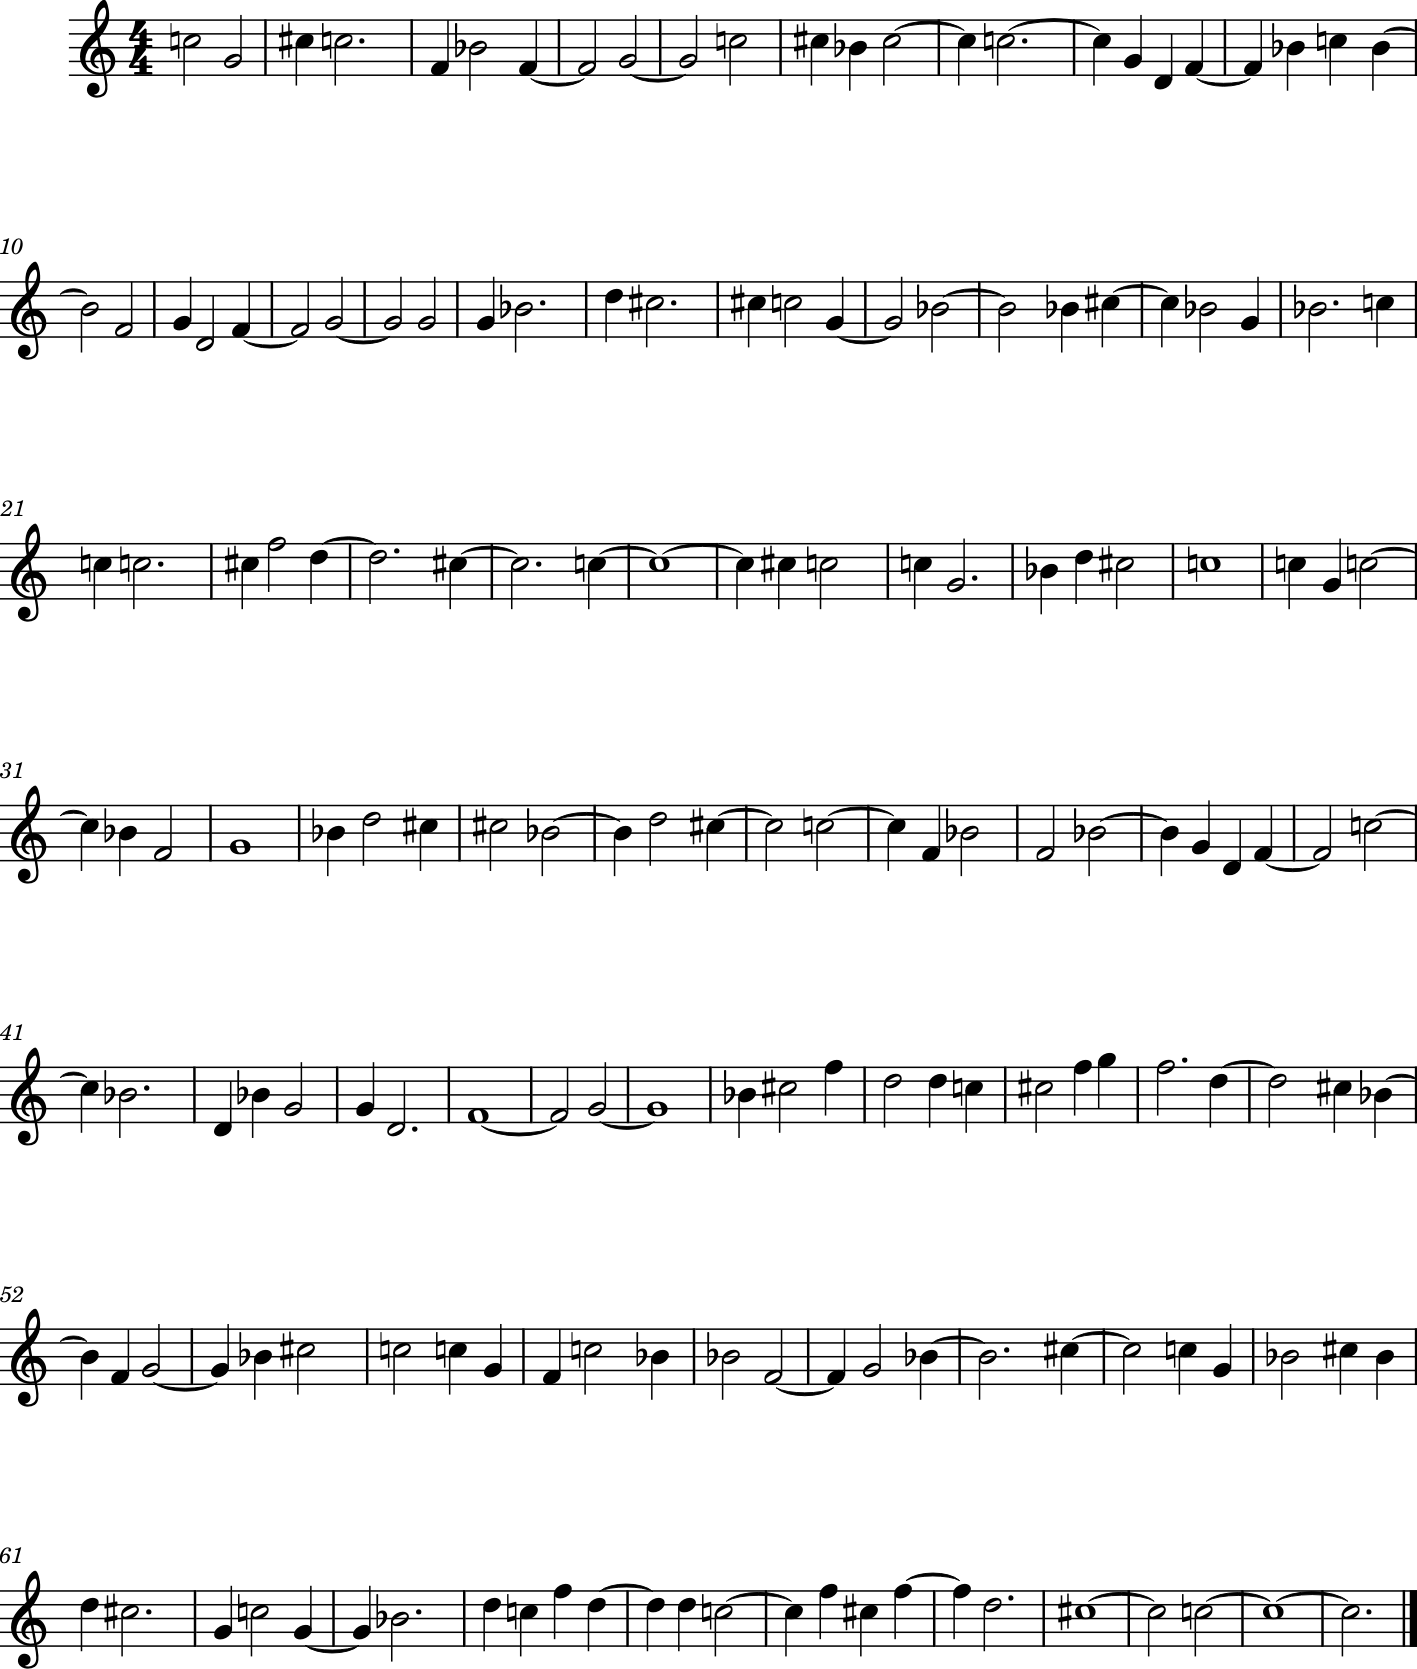

In [153]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"
us['musicxmlPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"

def generate_music_stochastic(lsystem_string):
    s1 = stream.Stream()
    F_major = scale.WeightedHexatonicBlues('G')
    scale_notes = F_major.getPitches('G2', 'G6')
    current_note_idx = len(scale_notes) // 2  # Start in middle of range
    current_duration = 0
    stack = []

    # Process each character in the L-system string
    for char in lsystem_string:
        if char == 'F':
            current_duration += 1.0  # Add quarter note duration
        elif char == '+':
            current_note_idx = min(current_note_idx + 1, len(scale_notes) - 1)
        elif char == '-':
            current_note_idx = max(current_note_idx - 1, 0)
        elif char == '[':
            stack.append((current_note_idx, current_duration))
            current_duration = 0
        elif char == ']':
            if current_duration > 0:
                n = note.Note(scale_notes[current_note_idx], quarterLength=current_duration)
                s1.append(n)
            current_note_idx, current_duration = stack.pop()

    return s1

s1 = generate_music_stochastic(generated_string)

s1.show()

In [154]:
for element in s1.recurse():
    if hasattr(element, 'duration'):
        element.duration.quarterLength /= 2.0
    if hasattr(element, 'offset'):
        element.offset /= 4.0

s1.write('midi', 'comp1.mid')
s1.show('midi')